# Imports and defs

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn as skl
import xgboost as xgb
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
np.set_printoptions(edgeitems=100)

#import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
%matplotlib inline 

from tqdm import tqdm_notebook
from itertools import product

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

#import gc

In [2]:
for p in [np, pd, skl, xgb]:
    print (p.__name__, p.__version__)

numpy 1.15.4
pandas 0.23.4
sklearn 0.20.1
xgboost 0.81


In [3]:
seed = 123
ctx = 'Bank_Marketing_Case'

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

def score(est, ground_truths, predictions):
    print(est)
    print('RMSE is %f' % np.sqrt(mean_squared_error(ground_truths, predictions)))
    print('R-squared is %f' % r2_score(ground_truths, predictions))    

In [5]:
import h5py

CACHE_FOLDER = './cache/'
KEY = 'dataset_1'

def save_data(filename, data):
    path = str(os.path.join(CACHE_FOLDER, filename) + '.h5')
    print('Saving ' + path)
    if isinstance(data, pd.DataFrame):
        data.to_hdf(path, KEY, mode='w')
    elif isinstance(data, np.ndarray):
        with h5py.File(path, 'w') as f:
            f.create_dataset(KEY, data=data)
    else:
        raise('Not supported')
    
def load_data(filename, hint):
    path = str(os.path.join(CACHE_FOLDER, filename) + '.h5')
    print('Loading ' + path)
    if isinstance(hint, pd.DataFrame):
        data = pd.read_hdf(path, KEY)
    elif isinstance(hint, np.ndarray):
        with h5py.File(path,'r') as f:
            data = f[KEY][:]
    else:
        raise('Not supported')
        
    return data

In [6]:
from joblib import dump, load
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model as keras_load_model

MODEL_FOLDER = './models/'

def save_model(filename, model):
    path = str(os.path.join(MODEL_FOLDER, filename) + '.jlib')
    print('Saving ' + path)    
    if isinstance(model, KerasRegressor):
        model.model.save(path)
    else:
        dump(model, path)        
        
def load_model(filename, hint):
    path = str(os.path.join(MODEL_FOLDER, filename) + '.jlib')
    print('Loading ' + path)
    if isinstance(hint, KerasRegressor):
        model = keras_load_model(path)
    else:
        model = load(path)
        
    return model        

Using TensorFlow backend.


# Explore Data

Bank Marketing Dataset Description

Goal: The binary classification goal is to predict if the customer will subscribe to a specific financial product (variable '21 target').

Input variables:

* 1  age                       age of the customer
* 2  occupation                type of job
* 3  marital_status            marital status
* 4  education                 type of education
* 5  has_credit                customer has credit by default
* 6  housing_loan              customer has housing loan
* 7  personal_loan             customer has personal loan
* 8  contact_mode              contact communication mode
* 9  month                     last contact month of year
* 10 week_day                  last contact day of the week
* 11 last_contact_duration     last contact duration, in seconds
* 12 contacts_per_campaign     number of contacts performed during this campaign and for this customer
* 13 N_last_days               number of days elapsed after the customer was last contacted for previous campaign
* 14 nb_previous_contact       number of contacts performed before this campaign and for this customer
* 15 previous_outcome          outcome of the previous marketing campaign
* 16 emp_var_rate              employment variation rate (quarterly indicator)
* 17 cons_price_index          consumer price index (monthly indicator)
* 18 cons_conf_index           consumer confidence index (monthly indicator)
* 19 euri_3_month              3 month rate (daily indicator)
* 20 nb_employees              number of employees (quaterly indicator)

Output variable:

* 21 target                    has the client subscribed to a specific financial product

In [7]:
DATA_FOLDER = './data/'

raw = pd.read_csv(os.path.join(DATA_FOLDER, 'bank_dataset.csv'))
raw.head()

,age,occupation,marital_status,education,has_credit,housing_loan,personal_loan,contact_mode,month,week_day,last_contact_duration,contacts_per_campaign,N_last_days,nb_previous_contact,previous_outcome,emp_var_rate,cons_price_index,cons_conf_index,euri_3_month,nb_employees,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Quick inspection of feature domains

In [26]:
raw.occupation.unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [27]:
raw.marital_status.unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [28]:
raw.education.unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [29]:
raw.has_credit.unique()

array(['no', 'unknown', 'yes'], dtype=object)

In [30]:
raw.housing_loan.unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [31]:
raw.personal_loan.unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [32]:
raw.contact_mode.unique()

array(['telephone', 'cellular'], dtype=object)

In [39]:
print(raw.month.nunique())
raw.month.unique()

10


array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

In [34]:
raw.week_day.unique()

array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object)

In [35]:
raw.previous_outcome.unique()

array(['nonexistent', 'failure', 'success'], dtype=object)

In [36]:
raw.target.unique()

array(['no', 'yes'], dtype=object)

In [40]:
raw.describe()

,age,last_contact_duration,contacts_per_campaign,N_last_days,nb_previous_contact,emp_var_rate,cons_price_index,cons_conf_index,euri_3_month,nb_employees
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [37]:
raw.isnull().describe()

,age,occupation,marital_status,education,has_credit,housing_loan,personal_loan,contact_mode,month,week_day,last_contact_duration,contacts_per_campaign,N_last_days,nb_previous_contact,previous_outcome,emp_var_rate,cons_price_index,cons_conf_index,euri_3_month,nb_employees,target
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188



## Quick plotting of features

In [63]:
def quick_plot_numeric(fig_num, feature):
    plt.figure(fig_num, figsize=(12,6))
    plt.suptitle(feature.name)
    plt.subplot(211)
    plt.hist(feature, bins=np.arange(100))
    plt.xlabel(feature.name)
    plt.ylabel('Count')
    plt.subplot(212)
    plt.plot(feature, '.')
    plt.xlabel('Index')
    plt.ylabel(feature.name)
    plt.show()
    
def quick_plot_categorical(fig_num, feature):
    feature.value_counts().plot(kind='bar')
    plt.figure(fig_num, figsize=(12,6))
    plt.suptitle(feature.name)
    plt.subplot(111)
    plt.scatter(range(len(feature)),feature)
    plt.xlabel(feature.name)
    plt.ylabel('Count')    


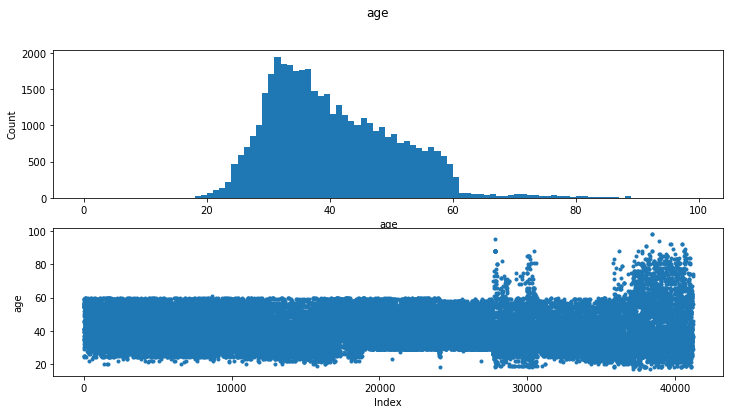

In [53]:
quick_plot_numeric(1, raw.age)

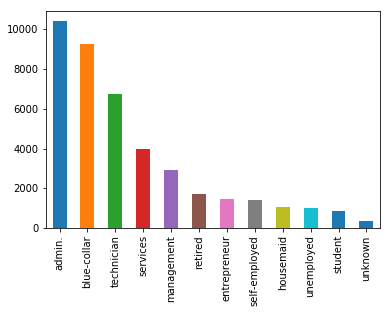

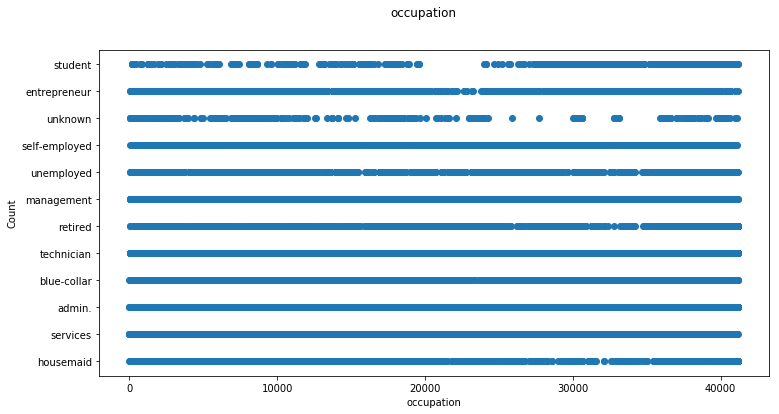

In [64]:
quick_plot_categorical(2, raw.occupation)

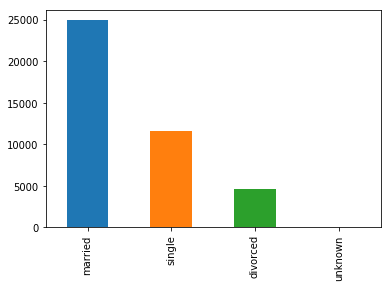

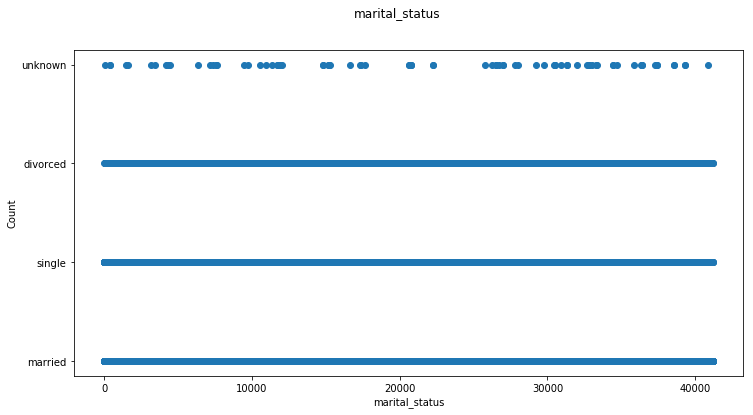

In [65]:
quick_plot_categorical(3, raw.marital_status)

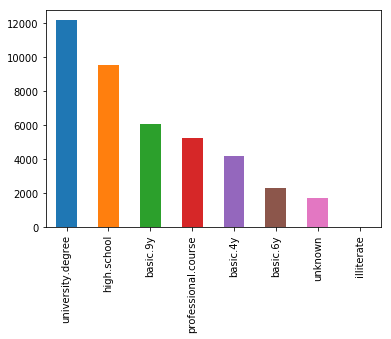

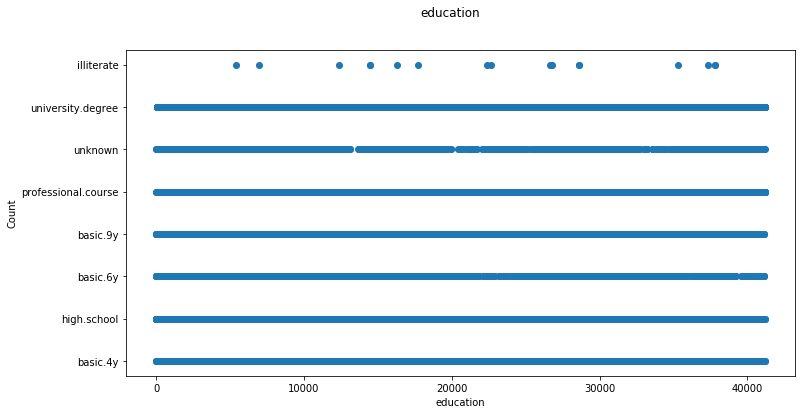

In [66]:
quick_plot_categorical(4, raw.education)

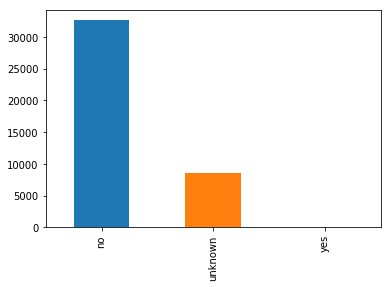

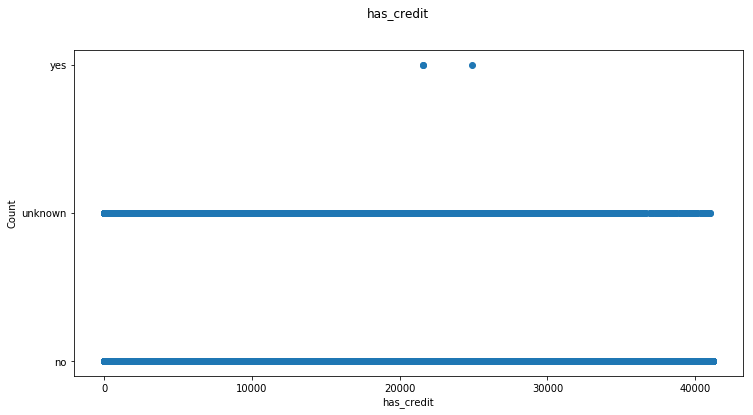

In [67]:
quick_plot_categorical(5, raw.has_credit)

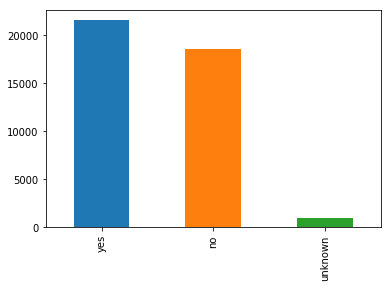

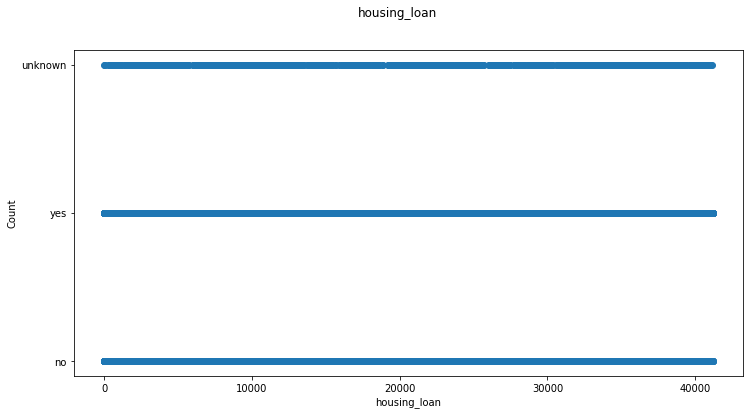

In [68]:
quick_plot_categorical(6, raw.housing_loan)

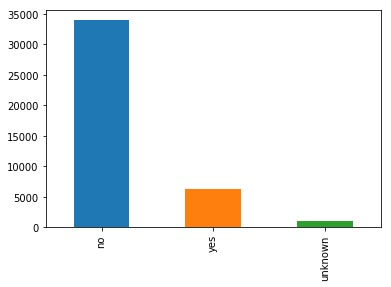

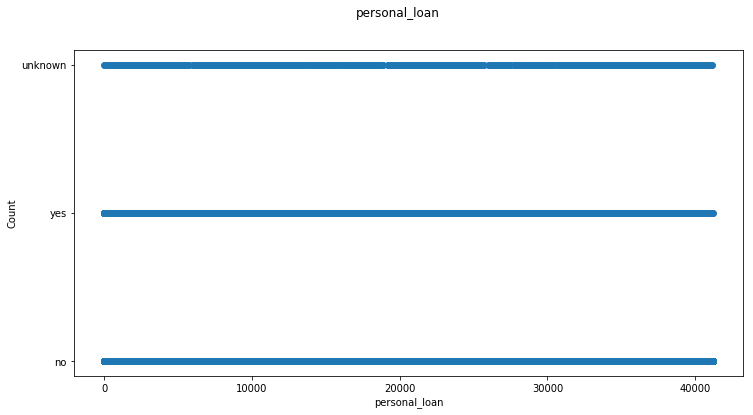

In [69]:
quick_plot_categorical(7, raw.personal_loan)

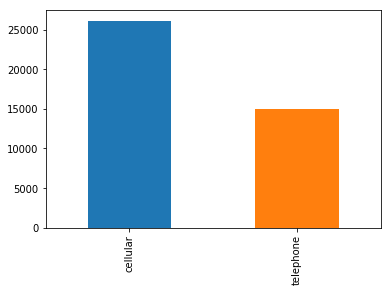

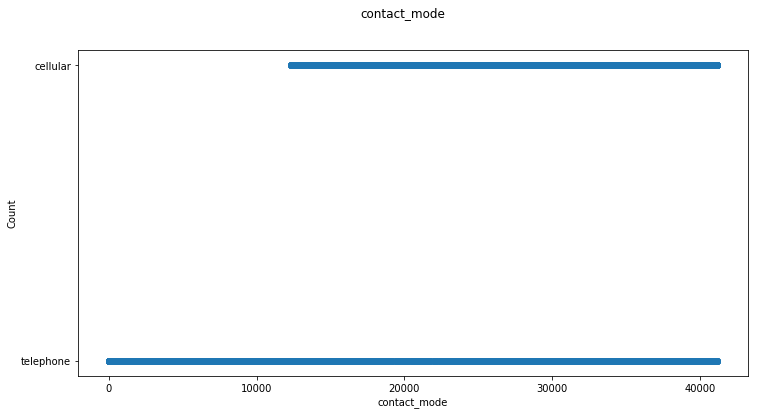

In [70]:
quick_plot_categorical(8, raw.contact_modea)

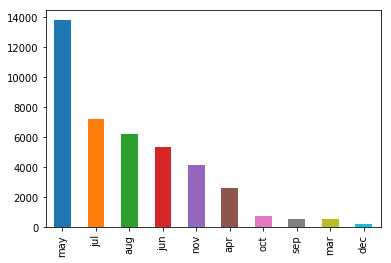

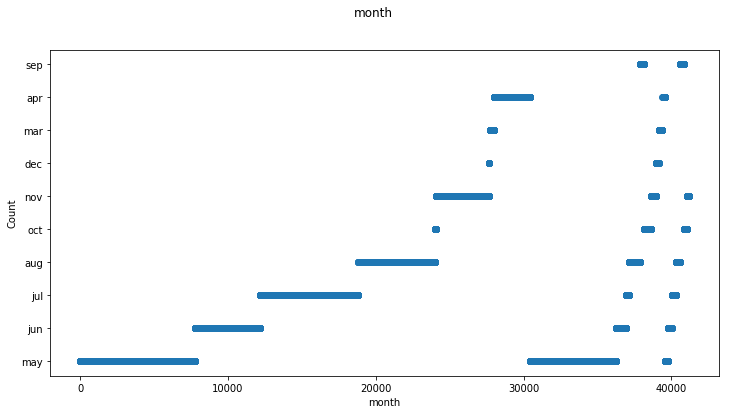

In [71]:
quick_plot_categorical(9, raw.month)

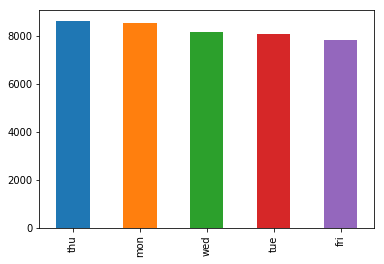

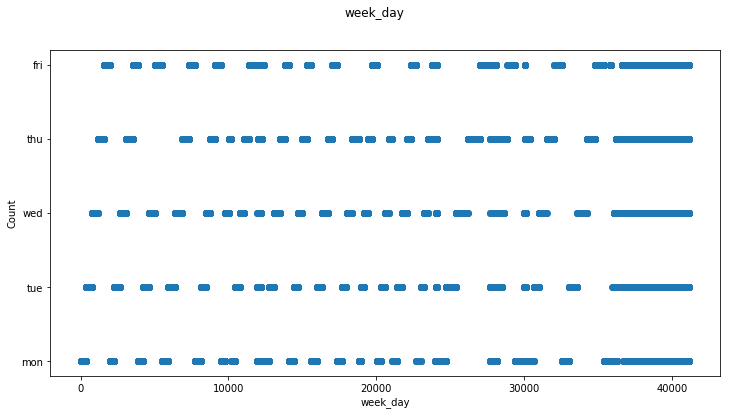

In [72]:
quick_plot_categorical(10, raw.week_day)

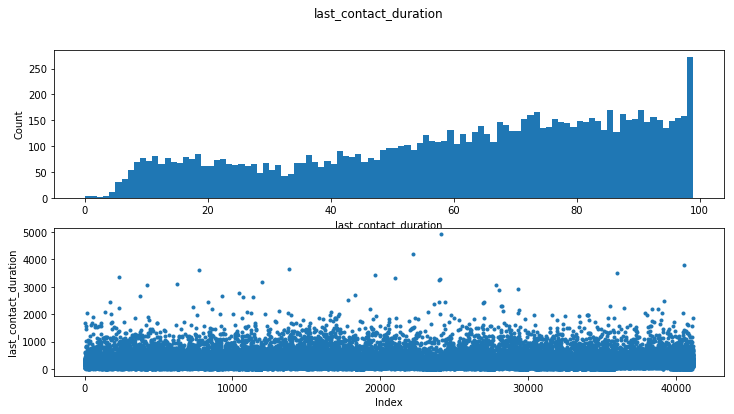

In [73]:
quick_plot_numeric(11, raw.last_contact_duration)

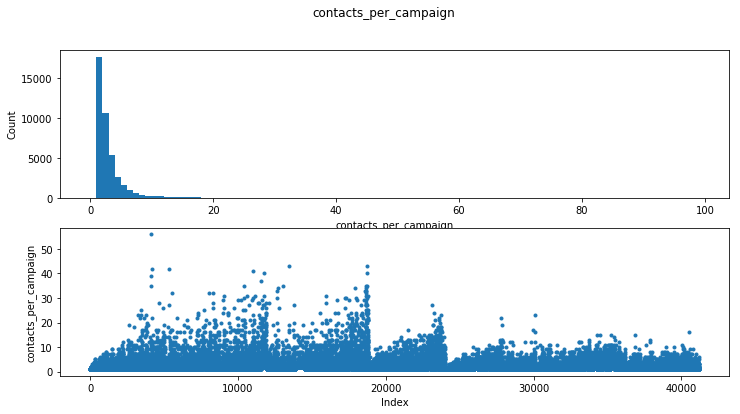

In [74]:
quick_plot_numeric(12, raw.contacts_per_campaign)

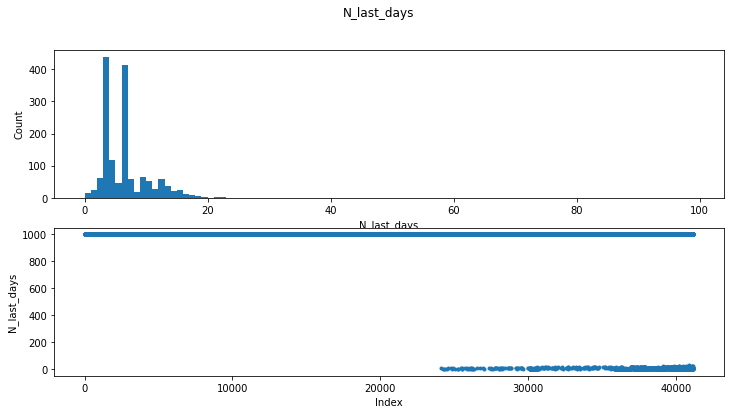

In [75]:
quick_plot_numeric(12, raw.N_last_days)

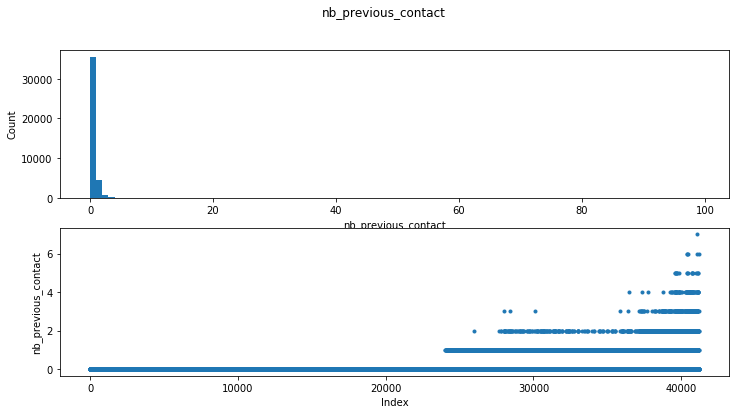

In [76]:
quick_plot_numeric(14, raw.nb_previous_contact)

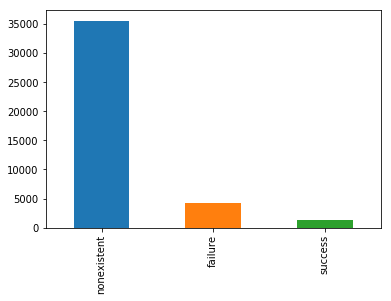

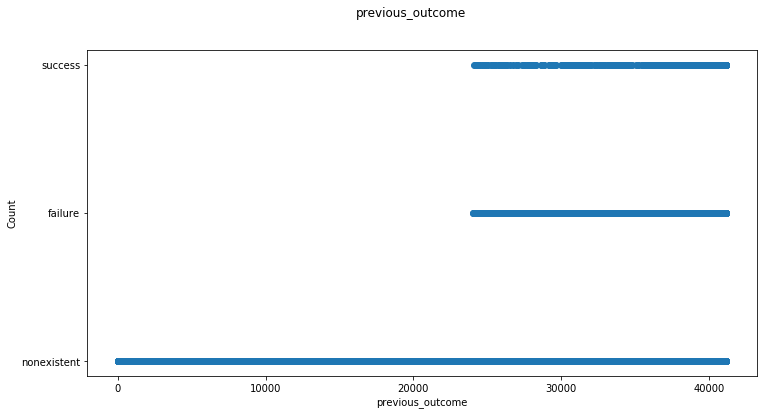

In [78]:
quick_plot_categorical(15, raw.previous_outcome)

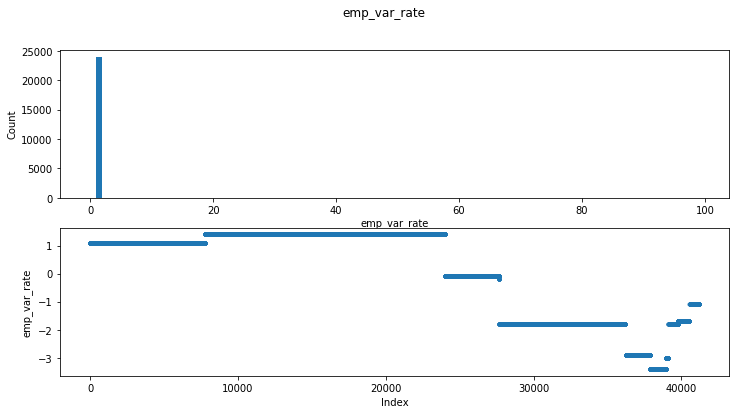

In [79]:
quick_plot_numeric(16, raw.emp_var_rate)

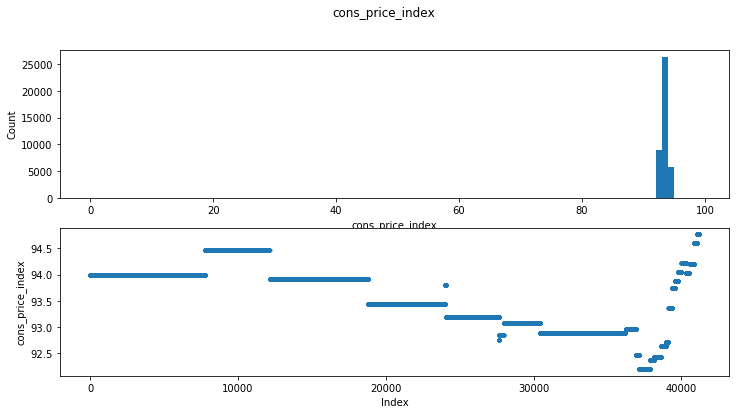

In [80]:
quick_plot_numeric(17, raw.cons_price_index)

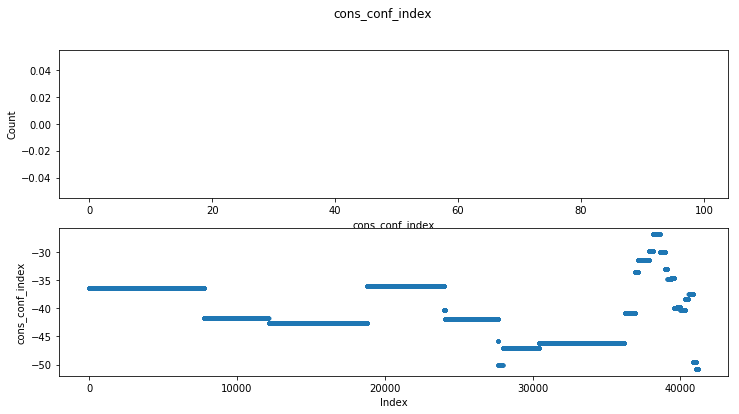

In [81]:
quick_plot_numeric(18, raw.cons_conf_index)

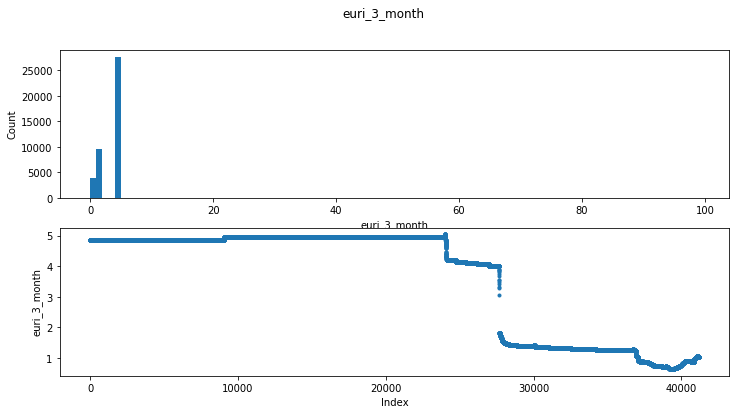

In [82]:
quick_plot_numeric(19, raw.euri_3_month)

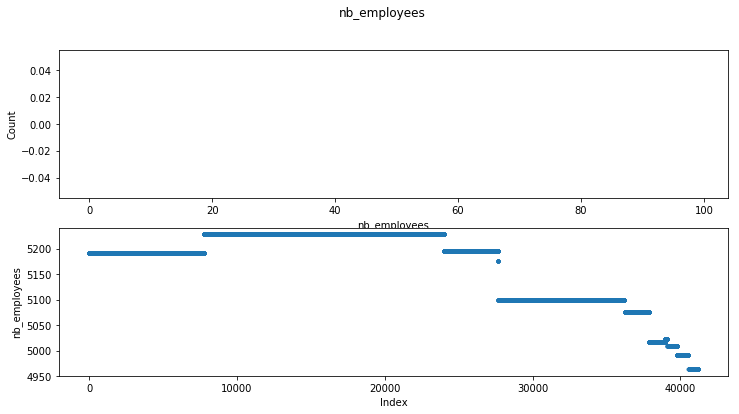

In [83]:
quick_plot_numeric(20, raw.nb_employees)

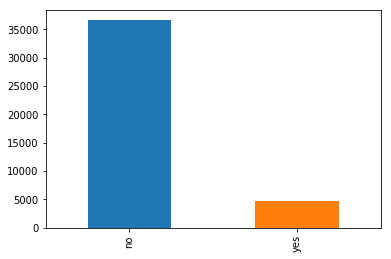

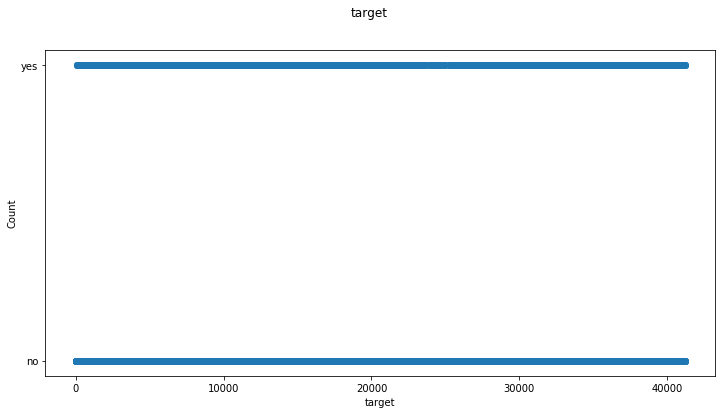

In [84]:
quick_plot_categorical(21, raw.target)

## Quick plotting of relations

/home/mortennp/anaconda3/envs/AdvML3_6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff621b6bc18>,
      dtype=object)

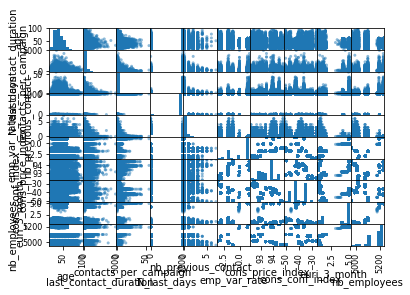

In [85]:
pd.scatter_matrix(raw)

# Feature engineering

In [98]:
categorical_features = ['occupation', 'marital_status', 'education', 'has_credit', 'housing_loan', 'personal_loan', 'contact_mode', 'month', 'week_day', 'previous_outcome']
numeric_features = ['age', 'last_contact_duration', 'contacts_per_campaign', 'N_last_days', 'nb_previous_contact', 'emp_var_rate', 'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees']
target_feature = ['target']

In [99]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper, gen_features

def create_mapper():
    categorial_maps = gen_features(
        columns=[[feature] for feature in categorical_features],
        classes=[{'class': OneHotEncoder, 'dtype': np.float32, 'sparse':False, 'handle_unknown':'ignore'}])
    numeric_maps = gen_features(
        columns=[[feature] for feature in numeric_features],
        classes=[StandardScaler])
    target_map = gen_features(
        columns=[[feature] for feature in target_feature],
        classes=[LabelEncoder])

    return DataFrameMapper(categorial_maps + numeric_maps + target_map, default=None)

In [100]:
mapper = create_mapper()
mapped_data = mapper.fit_transform(raw).astype(np.float32)
#mapper.transformed_names_

/home/mortennp/anaconda3/envs/AdvML3_6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mortennp/anaconda3/envs/AdvML3_6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mortennp/anaconda3/envs/AdvML3_6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mortennp/anaconda3/envs/AdvML3_6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mortennp/anaconda3/envs/AdvML3_6/lib/p

In [102]:
mapped_data

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [ ]:
#train = lagged_data.loc[lagged_data.date_block_num <= max_train_date_block_num]
#test_lagged = lagged_data.loc[lagged_data.date_block_num == max_train_date_block_num + 1]
train_indices = lagged_data.date_block_num <= max_train_date_block_num
test_indices = lagged_data.date_block_num == max_train_date_block_num + 1

In [ ]:
X_train = mapped_data[train_indices]
X_test = mapped_data[test_indices]

target_col = 'target'
y_train = lagged_data.loc[train_indices, [target_col]].values.ravel()

In [ ]:
dates_train=lagged_data.loc[train_indices,['date_block_num']]
#dates_train.head()
predictions = lagged_data.loc[test_indices, ['shop_id', 'item_id']]
#predictions.head()

In [ ]:
del lagged_data
del mapped_data
gc.collect()

In [ ]:
%pinfo2 np.empty

In [ ]:
save_data(ctx + 'X_train', X_train)
save_data(ctx + 'X_test', X_test)
save_data(ctx + 'y_train', y_train)
save_data(ctx + 'dates_train', dates_train)
save_data(ctx + 'predictions', predictions)

In [ ]:
X_train = load_data(ctx + 'X_train', np.empty(0))
X_test = load_data(ctx + 'X_test', np.empty(0))
y_train = load_data(ctx + 'y_train', np.empty(0))
dates_train = load_data(ctx + 'dates_train', pd.DataFrame())
predictions = load_data(ctx + 'predictions', pd.DataFrame())

In [ ]:
#print(X_train) 
#print(X_test)
#print(y_train) 
#print(dates_train)
#print(predictions)
X_train.dtype
X_train.shape
dates_train.shape

In [ ]:
def gen_time_split(data, n_splits):
    for i in range(n_splits):
        #print(i)
        first_vali_date_block_num = max_train_date_block_num - i
        vali_indices = data.loc[:,'date_block_num'] == first_vali_date_block_num
        train_indices = data.loc[:,'date_block_num'] < first_vali_date_block_num
        yield (train_indices[train_indices].index.values, vali_indices[vali_indices].index.values)

In [ ]:
xgb_est_filename = ctx + 'xgb_est.joblib'
#xgb_est = load(xgb_est_filename)
xgb_est = xgb.XGBRegressor(objective='reg:linear', n_jobs=-1, silent=0, **{'tree_method':'gpu_hist'}) #n_estimators=100, learning_rate=0.3, max_depth=7, 
#xgb_est.fit(X_train, y_train, verbose=2)
#dump(xgb_est, xgb_est_filename)
#xgb_est.get_params(deep=True)
#xgb_est.get_xgb_params()

In [ ]:
from sklearn.model_selection import GridSearchCV
search_est = GridSearchCV(xgb_est,
                          {'n_estimators':[50, 100, 150], 'learning_rate':[0.1, 0.3], 'max_depth':[6,7,8]},
                          scoring='neg_mean_squared_error',
                          cv=gen_time_split(dates_train, 3),
                          refit=True,
                          return_train_score=True,
                          verbose=2)
search_est.fit(X_train, y_train, verbose=2)

In [ ]:
search_est.cv_results_
search_est.best_score_

In [ ]:
dump(search_est.best_estimator_, xgb_est_filename)

In [ ]:
score("XGB train", y_train, search_est.predict(X_train))

RMSE for XGBoost is 0.857923
Train R-squared for XGBoost is 0.507406

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD, Adam

def create_keras_model(lr=0.1):
    model = Sequential()
    model.add(Dense(1000, activation='sigmoid'))
    model.add(Dense(300, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(1))
    model.compile(
        loss='mean_squared_error',
        optimizer='adam'
        #optimizer=SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False)
    )
    return model

keras_est_filename = ctx + 'keras_est'
keras_est = KerasRegressor(build_fn=create_keras_model, epochs=1, verbose=True) #lr=0.1, batch_size=10000, 

In [ ]:
keras_est_loaded = KerasRegressor(build_fn=create_keras_model, epochs=1, verbose=True) #lr=0.1, batch_size=10000, 
keras_est_loaded.model = load_model(keras_est_filename + '_model', keras_est_loaded)
keras_est_loaded.fit(X_train, y_train, verbose=True)

In [ ]:
keras_est_loaded.get_params()

In [ ]:
from sklearn.model_selection import GridSearchCV
search_est = GridSearchCV(keras_est,
                          {'lr':[0.003, 0.001, 0.01], 'batch_size': [1000, 300, 100]}, #'epochs': [3,5,7], 
                          scoring='neg_mean_squared_error',
                          cv=gen_time_split(dates_train, 3),
                          refit=True,
                          return_train_score=True,
                          verbose=2)
search_est.fit(X_train, y_train, verbose=True)

In [ ]:
search_est.best_score_
search_est.best_params_
search_est.cv_results_

In [ ]:
save_model(keras_est_filename + '_cv_results', search_est.cv_results_)

In [ ]:
save_model(keras_est_filename + '_model', search_est.best_estimator_)

In [ ]:
y_test_pred = search_est.best_estimator_.predict(X_train)
score("Keras train", y_train, y_test_pred)

In [ ]:
y_test_pred = None
predictions = predictions.assign(item_cnt_month=y_test_pred)
submission = test.merge(predictions, how='left')[['item_cnt_month']]
submission.head()
submission.to_csv(ctx + '.csv.gz', index_label='ID', compression='gzip') #header=['ID', 'item_cnt_month'])